# PINN for Laplace Equation - Training on Dataset
(Please reference to our paper **Physics-Informed Boundary Integral Networks (PIBI-Nets): a Data-Driven Approach for Solving Partial Differential Equations**.)

---

## Problem setup

We want to solve the Laplace equation
$$ \Delta u(x) := \frac{\partial^2 u}{\partial x_1^2} + \frac{\partial^2 u}{\partial x_2^2} = 0 $$
with
$$x:=(x_1, x_2)\, \in \,\left([-1,1]\times [-1,1]\right)=:\Omega \subseteq \mathbb{R}^2$$
alligned to observations ${\large\{}u_i(x){\large\}}_{i=0}^{i=N}$ in $\Omega$.


## Initial settings

In [1]:
# load packages
import torch
import torch.nn as nn
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.font_manager import FontProperties
import os
from datetime import datetime
from sklearn.model_selection import KFold

In [2]:
# plot specifications
matplotlib.rcParams['text.usetex'] = True
# font properties for axis
font_axis = FontProperties()
font_axis.set_family('serif')
font_axis.set_name('Times New Roman')
font_axis.set_size(115)
# font properties for 3d plot axis
font_axis_3d = FontProperties()
font_axis_3d.set_family('serif')
font_axis_3d.set_name('Times New Roman')
font_axis_3d.set_size(90)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Create dataset

In [4]:
def f_rhs(x, y, sources):
    rhs = 0
    for source in sources:
        x_source, y_source, c_source = source
        tol = 0.01
        if np.abs(x - x_source) <= tol and np.abs(y - y_source) <= tol:
            rhs += c_source
    return rhs

Number of sources: 5
[[ 0.73327409 -0.4737103   3.08318689]
 [-0.2678551  -0.27956146 -3.42660729]
 [-0.76114308 -0.38173389  4.20422662]
 [-0.40125419  0.09517222  4.78502639]
 [-0.79582369  0.41304773 -3.02831527]]


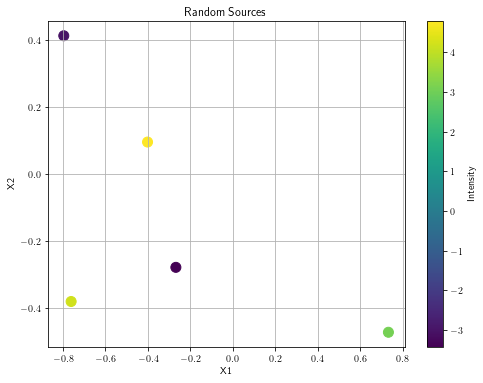

In [5]:
def set_sources(randomness):
    np.random.seed(randomness)
    S = 5#np.random.randint(5, 15) # number of sources
    print('Number of sources:', S)
    sources = []
    for s in range(S):
        x1_s = np.random.uniform(-1, 1)
        x2_s = np.random.uniform(-1, 1)
        random_value1 = np.random.uniform(-5, -3)
        random_value2 = np.random.uniform(3, 5)
        c_s = np.random.choice([random_value1, random_value2])
        sources.append((x1_s, x2_s, c_s))
    sources = np.array(sources)
    print(sources)

    # Extracting coordinates and intensities for plotting
    xs1 = [source[0] for source in sources]
    xs2 = [source[1] for source in sources]
    intensities = [source[2] for source in sources]
    source_list = np.array([xs1, xs2, intensities]).T
    source_tensor = torch.tensor(source_list, dtype=torch.float32) # x1, x2, u
    np.savetxt("source_data.csv", source_list, delimiter=",", header="x1,x2,mag", fmt="%.8f", comments='')

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(xs1, xs2, c=intensities, cmap='viridis', s=100)
    plt.colorbar(label='Intensity')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Random Sources')
    plt.grid(True)
    plt.show()

    return source_tensor

randomness = 123+5
sources = set_sources(randomness)

In [6]:
# build mesh
n = 101 # grid size
x1 = np.linspace(-1, 1 , n) # (n,)
x2 = np.linspace(-1, 1 , n)
X1, X2 = np.meshgrid(x1, x2) # (n,n)

# solve pde by using finite differences
def laplace_equation(X1, X2): # n: integer, n*n number of gridpoints in domain Omega

    # -------------------------------------
    # boundary conditions sin curves waterfall
    def u_sin(x):
        return np.sin(2.5*np.pi*x+2*np.pi)
    def u_const(x):
        return np.ones_like(x)

    U = np.zeros((n, n))
    U[:,0] = u_sin(X2[:,0])
    U[0,:] =  -u_const(X1[0,:])
    U[-1,:] = u_const(X1[-1,:])
    U[:,-1] = u_sin(X2[:,-1])

    # FD-iteration to find pde solution
    tol = 1e-3 # adjustable residuum precision
    maxiter = 10_000 # adjustable maximum number of iterations
    for iter in range(maxiter):
        U_prev = np.copy(U)
        for i in range(1,n-1):
            for j in range(1,n-1):
                U[i,j] = (U[i+1,j] + U[i-1,j] + U[i,j+1] + U[i,j-1] + f_rhs(X1[i,j], X2[i,j], sources))/4
        print('res', np.linalg.norm(U-U_prev), 'iter', iter)
        # check if the solution has converged
        if np.linalg.norm(U-U_prev) < tol:
            break
    return U

# compute the solution
U = laplace_equation(X1, X2)
# save solution in a vector as ground truth
N = X1.shape[0] * X1.shape[1]
XU_num = np.column_stack((X1.reshape(N,1), X2.reshape(N,1), U.reshape(N,1)))

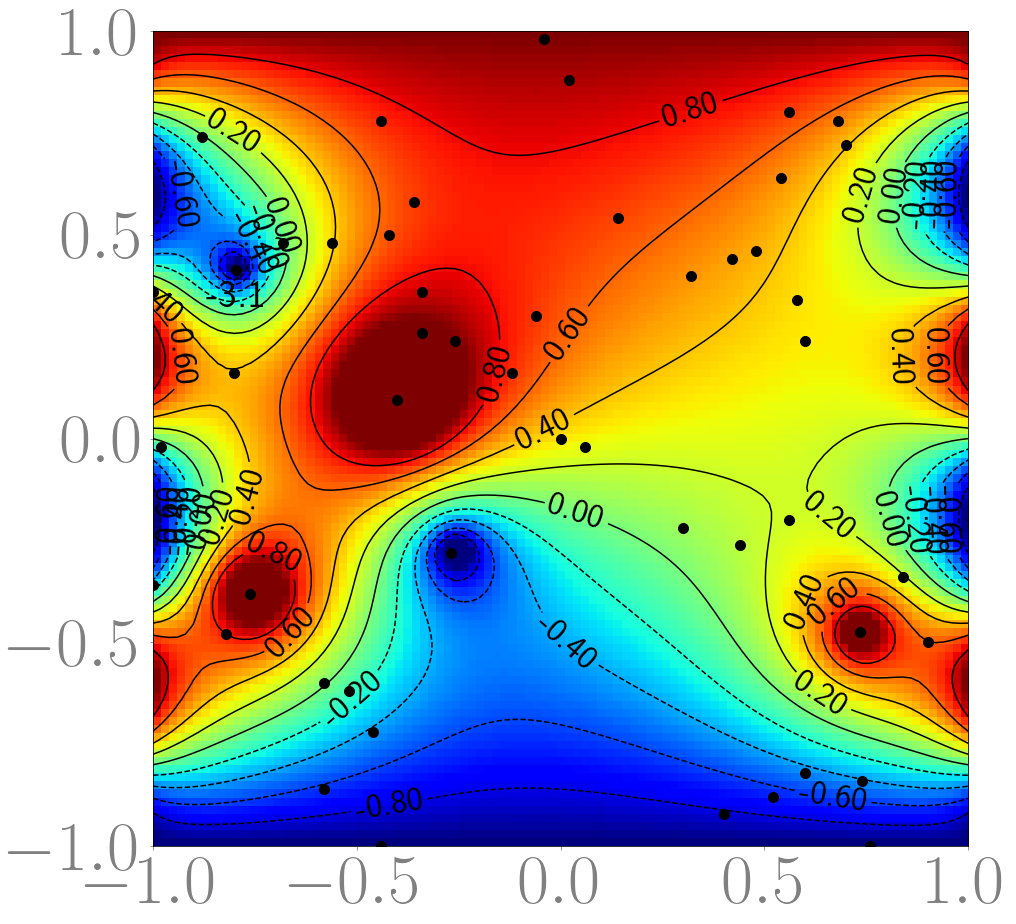

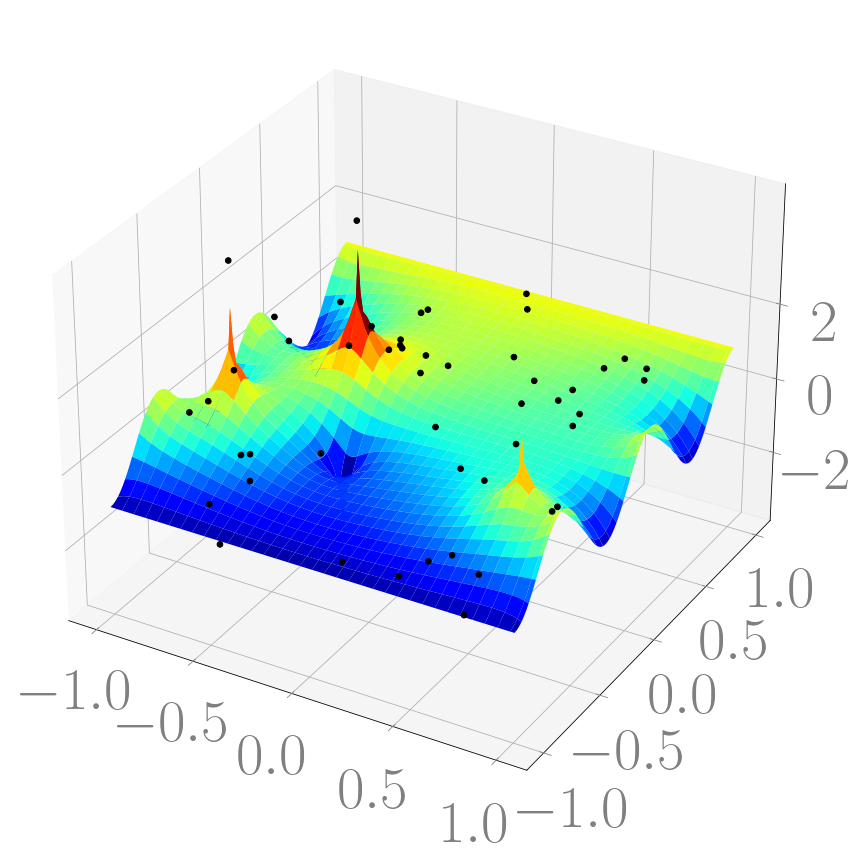

tensor([[-0.5200, -0.6200,  0.1202],
        [ 0.5600,  0.8000,  0.5653],
        [-0.4400, -1.0000, -1.0860],
        [ 0.4800,  0.4600,  0.4914],
        [-0.8000,  0.1600,  0.6740],
        [-0.8800,  0.7400,  0.1585],
        [-0.4600, -0.7200, -0.2250],
        [ 0.3000, -0.2200, -0.0651],
        [-1.0000,  0.3600,  0.5261],
        [-0.0600,  0.3000,  0.7420],
        [-0.3400,  0.3600,  0.7252],
        [ 0.9000, -0.5000,  0.5423],
        [-1.0000, -0.3600, -0.2013],
        [-0.5800, -0.6000, -0.0493],
        [ 0.7400, -0.8400, -0.3923],
        [-0.3400,  0.2600,  0.8569],
        [ 0.6000, -0.8200, -0.1778],
        [ 0.0600, -0.0200,  0.1287],
        [-0.0400,  0.9800,  0.9881],
        [ 0.6000,  0.2400,  0.2951],
        [-0.5800, -0.8600, -0.6388],
        [ 0.5400,  0.6400,  0.6914],
        [-0.4400,  0.7800,  0.4809],
        [ 0.7600, -1.0000, -0.9472],
        [ 0.5600, -0.2000,  0.9335],
        [ 0.5200, -0.8800, -0.2991],
        [ 0.4000, -0.9200, -0.7699],
 

In [7]:
def take_samples(XU_num, sources, n_samples, time_now, randomness): # take n_samples from the solution of the Laplace equation
    n_samples -= 6
    np.random.seed(123+randomness)
    n_outer_samples = int(1.0*n_samples)
    n_inner_samples = int(0.0*n_samples)
    mid = 0.0

    x_inner_filter_s = np.where(XU_num[:,0] > -mid, 1, 0)
    x_inner_filter_b = np.where(XU_num[:,0] < mid, 1, 0)
    y_inner_filter_s = np.where(XU_num[:,1] > -mid, 1, 0)
    y_inner_filter_b = np.where(XU_num[:,1] < mid, 1, 0)

    inner = x_inner_filter_s * x_inner_filter_b * y_inner_filter_s * y_inner_filter_b
    inner_ids = np.where(inner > 0)
    inner_num_sol = XU_num[inner_ids]
    inner_i = np.random.choice(len(inner_num_sol), n_inner_samples, replace=False)
    inner_points = inner_num_sol[inner_i]

    outer = 1-inner
    outer_ids = np.where(outer > 0)
    outer_num_sol = XU_num[outer_ids]
    outer_i = np.random.choice(len(outer_num_sol), n_outer_samples, replace=False)
    outer_points = outer_num_sol[outer_i]

    data = np.concatenate((inner_points, outer_points))

    # add one noisy point to middle
    noisy_point = np.array((0, 0, 2)).reshape(1,3)
    data = np.concatenate((data, noisy_point))

    #---------------------------------
    ## add source points
    data = np.concatenate((data, sources), 0)

    #---------------------------------
    ## add gaussian noise
    std = 0.1 * 2 # x * 2, with x percent noise
    noise_add = np.random.normal(loc=0, scale=std, size=data[:,-1].shape[0])
    data[:,-1] = data[:,-1] + noise_add

    #---------------------------------
    ## save data in new directory
    directory = f"{n_samples}_{time_now}"
    os.makedirs(directory, exist_ok=True)
    np.savetxt(f"{directory}/{randomness}_dataset_laplace.csv", data, delimiter=",", header="x1,x2,u", fmt="%.6f", comments='')

    #---------------------------------
    # 2D plot
    fig, ax = plt.subplots(figsize=(15, 15))
    img = ax.imshow(U, cmap='jet', origin='lower', extent=[np.min(X1), np.max(X1), np.min(X2), np.max(X2)], vmin=-1, vmax=1)
    ax.scatter(data[:,0], data[:,1], c='black', marker='o', s=10**2, alpha=1)
    #for i in range(len(data)):
    #    ax.text(data[i, 0], data[i, 1], f'{data[i, -1]:.1f}', fontsize=30, ha='center', va='bottom')
    ax.text(data[-1, 0], data[-1, 1]-0.02, f'{data[-1, -1]:.1f}', fontsize=40, ha='center', va='top')
    # Add contour lines
    contour_levels = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    contour_lines = ax.contour(x1, x2, U, levels=contour_levels, colors='k')
    ax.clabel(contour_lines, inline=True, fontsize=35, fmt='%1.2f')
    # axis ticks
    #ax.tick_params(axis="both", labelsize=40, pad=10)
    ax.tick_params(axis="both", labelsize=70, pad=5)
    major_ticks = [-1,-0.5,0, 0.5,1]
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    # tick colour
    ax.tick_params(axis='x', colors='grey')
    ax.tick_params(axis='y', colors='grey')
    plt.savefig(f'{directory}/{randomness}_num2d.pdf', dpi=500, format='pdf', bbox_inches='tight')
    if show_plots == True:
        plt.show()

    #---------------------------------
    # 3D plot
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
    surf = ax.plot_surface(X1, X2, U, cmap=cm.jet, linewidth=1, zorder=1)
    # plot points on top of surface
    ax.scatter(data[:,0], data[:,1], data[:,-1], c='black', marker='o', s=10**1.5, alpha=1, zorder=2)
    # axis ticks
    #ax.tick_params(axis="both", labelsize=40, pad=15)
    ax.tick_params(axis="both", labelsize=60, pad=20)
    major_ticks = [-1,-0.5,0, 0.5,1]
    major_ticks_z = [-2,0,2]
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    ax.set_zticks(major_ticks_z)
    # tick colour
    ax.tick_params(axis='x', colors='grey')
    ax.tick_params(axis='y', colors='grey')
    ax.tick_params(axis='z', colors='grey')
    plt.savefig(f'{directory}/{randomness}_num3d.pdf', dpi=500, format='pdf', bbox_inches='tight')
    if show_plots == True:
        plt.show()
    data = torch.tensor(data, dtype=torch.float64, device=device)
    return data

show_plots = True
time_now = datetime.now().strftime("%Y%m%d_%H%M")
take_samples(XU_num, sources, 50, time_now, 6)

## Collocation points

In [8]:
def collocation_points(n):

    # number of collocation points over entire domain for physics / pde loss
    x1_collocation = torch.DoubleTensor(n, 1).uniform_(-1, 1).to(device=device)
    x2_collocation = torch.DoubleTensor(n, 1).uniform_(-1, 1).to(device=device)
    x_collocation = torch.cat([x1_collocation, x2_collocation], axis=1).requires_grad_(True).to(device=device)

    return x_collocation

## Physics initialisation

In [9]:
#  pde function at position x=(x1,x2) in Omega, given a network
def pde(x, u):

    # compute gradients for pde
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u, device=device), create_graph=True)[0] # (du_dx1, du_dx2) of shape (N,2)
    d2u_dx1x1 = torch.autograd.grad(du_dx[:,0], x, grad_outputs=torch.ones_like(du_dx[:,0], device=device), create_graph=True)[0][:,0].view(-1,1) # (d2u_dx1x1, d2u_dx1x2), but only take first column, shape (N,1)
    d2u_dx2x2 = torch.autograd.grad(du_dx[:,1], x, grad_outputs=torch.ones_like(du_dx[:,1], device=device), create_graph=True)[0][:,1].view(-1,1) # (d2u_dx2x1, d2u_dx2x2), but only take second column, shape (N,1)

    # compute pde
    u_pde = d2u_dx1x1 + d2u_dx2x2

    return u_pde

## Network setup

In [10]:
# fully-connected neural network setup with PyTorch
class FCNN(nn.Module):
    def __init__(self, N_input, N_output, N_hidden, N_layers, sources):

        super().__init__()
        activation = nn.Tanh

        # initialise parameters of sink and source terms
        random_mag = 0.5*(2*torch.rand(5,1)-1)
        self.mag = nn.Parameter(sources[:,-1].view(-1,1)+random_mag, requires_grad=True)
        random_shift = 0.01*(2*torch.rand(5,2)-1)
        self.loc = nn.Parameter(sources[:,0:2]+random_shift, requires_grad=True)

        # input / start layer
        self.fc_start = nn.Sequential(*[
                                nn.Linear(N_input, N_hidden, dtype=torch.float64),
                                activation()
                                ])
        # hidden layers
        self.fc_hidden = nn.Sequential(*[
                                nn.Sequential(*[
                                    nn.Linear(N_hidden, N_hidden, dtype=torch.float64),
                                    activation()
                                    ])
                                for _ in range(N_layers-1) # -1 since first layer already defined before for-loop
                                ])
        # output / end layer
        self.fc_end = nn.Linear(N_hidden, N_output, dtype=torch.float64) # for regression, no activation is used in output layer

    #------------------------------
    def forward(self, x):
        # forward pass through network
        x = self.fc_start(x)  # input layer
        x = self.fc_hidden(x) # hidden layer(s)
        u = self.fc_end(x)    # output layer

        return u

In [11]:
def initialise_pinn(lr, sources):
    # define number of neurons in each layer type
    N_input  = 2
    N_output = 1
    N_hidden = 64 # changeable, use 2**n for efficient memory usage and computation
    N_layers = 3 # number of hidden layers

    # define a neural network to train
    pinn = FCNN(N_input, N_output, N_hidden, N_layers, sources).to(device=device)

    # optimizer
    optimiser = torch.optim.Adam(pinn.parameters(), lr=lr)

    # loss function
    mse_loss = torch.nn.MSELoss() # Mean squared error

    return pinn, optimiser, mse_loss

## Train PINN and visualise trained solution

In [12]:
# plot loss convergence
def plot_loss(loss_values, loss_data_values, loss_pde_values, n_samples, n_coll, data_n, time_now):
    epochs = list(range(1,len(loss_values)+1))

    # Gaussian smoothing
    sigma = 20
    smoothed_loss_values = gaussian_filter1d(loss_values, 5)
    smoothed_loss_data_values = gaussian_filter1d(loss_data_values, 5)
    smoothed_loss_pde_values = gaussian_filter1d(loss_pde_values, sigma)

    fig, axs = plt.subplots(1, 2, figsize=(30, 15))
    # loss plot
    axs[0].plot(epochs, loss_values)
    axs[0].plot(epochs, loss_data_values)
    axs[0].plot(epochs, loss_pde_values)
    #axs[0].set_yscale('log')
    axs[0].tick_params(axis="both", labelsize=20, pad=5)
    axs[0].tick_params(axis='x', colors='grey')
    axs[0].tick_params(axis='y', colors='grey')
    axs[0].set_xlabel('iterations')
    axs[0].set_ylabel('log(loss)')
    axs[0].set_title('Convergence', size=20)
    legend1 = axs[0].legend(['total loss', 'data loss', 'pde loss'])
    for text in legend1.get_texts():
        text.set_fontsize(20)

    # smoothed loss plot
    axs[1].plot(epochs, smoothed_loss_values)
    axs[1].plot(epochs, smoothed_loss_data_values)
    axs[1].plot(epochs, smoothed_loss_pde_values)
    #axs[1].set_yscale('log')
    axs[1].tick_params(axis="both", labelsize=15, pad=5)
    axs[1].tick_params(axis='x', colors='grey')
    axs[1].tick_params(axis='y', colors='grey')
    axs[1].set_xlabel('iterations')
    axs[1].set_ylabel('log(loss)')
    axs[1].set_title('Convergence', size=20)
    legend2 = axs[1].legend(['total loss', 'data loss', 'pde loss'])
    for text in legend2.get_texts():
        text.set_fontsize(20)

    # Adjust layout
    plt.tight_layout()

    # Save or display the plot
    directory = f"{n_samples}_{time_now}"
    plt.savefig(f'{directory}/{data_n}_{n_coll}_convergence.pdf', dpi=500, format='pdf', bbox_inches='tight')
    if show_plots == True:
        plt.show()

In [13]:
def calculate_lambda(data, iterations, n_samples, n_coll, time_now, sources):
    show_plots = False
    create_plot = False
    # lambda values for cross-validation
    lambda_values = [0.00000001,0.0000001,0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
    kf = KFold(n_splits=5)
    best_lambda = None
    best_avg_loss = float('inf')

    for lambda_val in lambda_values:
        avg_loss = 0.0
        for train_index, val_index in kf.split(data):
            train_data, val_data = data[train_index], data[val_index]

            # PINN initialization
            pinn, optimiser, mse_loss = initialise_pinn(lr, sources)

            # Train PINN
            pinn, end_loss, pinn_mean, pinn_std, error_vec = train_pinn(iterations, pinn, optimiser, mse_loss, lambda_val, train_data, 00, n_samples, n_coll, time_now, show_plots, create_plot)
            plt.close('all')

            # Validation loss calculation
            with torch.no_grad():
                val_loss = mse_loss(pinn(val_data[:, 0:2]).detach().view(-1,1), val_data[:, -1].view(-1,1))
            avg_loss += val_loss.item() / 5  # 5-fold average

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_lambda = lambda_val

    return best_lambda

In [14]:
def f_rhs(x1, x2, sources):
    rhs = 0
    for source in sources:
        x_source, y_source, c_source = source
        tol = 0.01
        if torch.abs(x1.detach() - x_source.detach()) <= tol and torch.abs(x2.detach() - y_source.detach()) <= tol:
            rhs += c_source
    return rhs

In [15]:
def train_pinn(iterations, pinn, optimiser, mse_loss, lambda_physics, data, data_n, n_samples, n_coll, time_now, show_plots, create_plot):
    n_samples -= 6

    # store loss values
    loss_values = []
    loss_pde_values = []
    loss_data_values = []
    pinn_mean = 0
    pinn_std = 0


    for epoch in range(iterations):
        # Clear gradients before forward and backward pass for each batch to avoid accumulation of gradients
        optimiser.zero_grad()

        # compute data loss
        u_d = pinn(data[:,0:2]) # forward pass
        loss_data = mse_loss(u_d, data[:,-1].view(-1,1))
        loss_data_values.append(loss_data.data)


        # compute physics loss
        x_collocation = collocation_points(n_coll)
        u_c = pinn(x_collocation)
        # compute right hand side
        rhs = torch.zeros_like(u_c)
        for i in range(len(x_collocation)):
            for j in range(len(sources)):
                #rhs[i] = rhs[i] + sources[j,2] * torch.exp(-((x_collocation[i,0]-sources[j,0])**2 + (x_collocation[i,1]-sources[j,1])**2))
                ss = torch.cat((pinn.loc[j].view(1,2), pinn.mag[j].view(1,1)),1)
                rhs[i] = rhs[i] + f_rhs(x_collocation[i,0], x_collocation[i,1], ss)
        loss_physics = mse_loss(pde(x_collocation, u_c), rhs)
        loss_pde_values.append(loss_physics.data)

        # backpropagate weighted joint loss, take optimiser step
        loss = loss_data + lambda_physics*loss_physics
        loss_values.append(loss.item()) # store loss value for convergence plot
        loss.backward()
        optimiser.step()

        '''
        # plot result as training progresses on test set
        if epoch % 100 == 0:
            print(epoch, '; loss', loss.item(), '; data:', loss_data.data.item(), '; physics:', loss_physics.data.item())
            for i in range(len(sources)):
                print('loc', pinn.loc[i].detach(), 'mag', pinn.mag[i].detach())
        '''


        if epoch == iterations-1:

            # FD solution
            XU_num_tensor = torch.tensor(XU_num, dtype=torch.float64, device=device)
            x1 = (XU_num_tensor[:, 0]).reshape((n, n))
            x2 = (XU_num_tensor[:, 1]).reshape((n, n))
            u_num = XU_num_tensor[:,-1].reshape(x1.shape)

            # evaluate PINN for plot points
            u_pinn = pinn(XU_num_tensor[:,0:2]) # (n*n,1)
            u_pinn = u_pinn.reshape(x1.shape)
            u_pinn = u_pinn.detach() # (101, 101)

            # error metrics for plot
            u_error = torch.abs(u_pinn-u_num)
            u_error_vec = u_error.reshape(n*n,1)
            pinn_mean = torch.mean(u_error_vec)
            pinn_std = torch.std(u_error_vec)
            print('min', torch.min(u_error_vec).item(), 'max', torch.max(u_error_vec).item(), 'mean', pinn_mean.item(), 'std', pinn_std.item())

            if create_plot == True:


                # save model
                directory = f"{n_samples}_{time_now}"
                torch.save(pinn.state_dict(), f'{directory}/{data_n}_{n_coll}_{lambda_physics}_pinn_model.pt')

                #---------------------------------
                # evaluation plot in 3D
                fig = plt.figure(figsize=(15,15))
                ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
                surf = ax.plot_surface(x1, x2, u_pinn, cmap=cm.jet, linewidth=1, zorder=1)
                ax.scatter(data[:,0], data[:,1], data[:,-1], c='black', marker='o', s=10**1.5, alpha=1, zorder=2)
                #for i in range(len(sources)):
                #    ax.scatter(pinn.loc[i][0].detach(), pinn.loc[i][1].detach(), pinn.mag[i].detach(), c='red', marker='o', s=10**2, alpha=1, zorder=2)
                #    print('loc', pinn.loc[i].detach(), 'mag', pinn.mag[i].detach())
                # axis ticks
                #ax.tick_params(axis="both", labelsize=40, pad=15)
                ax.tick_params(axis="both", labelsize=60, pad=20)
                major_ticks = [-1,-0.5,0, 0.5,1]
                major_ticks_z = [-2,0, 2]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                ax.set_zticks(major_ticks_z)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                ax.tick_params(axis='z', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis_3d, labelpad=55)
                ax.set_ylabel('$x_2$', fontproperties=font_axis_3d, labelpad=55)
                ax.set_zlabel('$u$', fontproperties=font_axis_3d, labelpad=55)
                plt.savefig(f'{directory}/{data_n}_{n_coll}_{lambda_physics}_pinn_3d.pdf', dpi=500, format='pdf', bbox_inches='tight')
                if show_plots == True:
                    plt.show()

                #---------------------------------
                # evaluation plot in 2d
                fig, ax = plt.subplots(figsize=(15, 15))
                img = ax.imshow(u_pinn, cmap='jet', origin='lower',
                                extent=[torch.min(x1).item(), torch.max(x1).item(),
                                        torch.min(x2).item(), torch.max(x2).item()],
                                vmin=-1, vmax=1)
                #for i in range(len(data)):
                #    ax.text(data[i, 0], data[i, 1], f'{data[i, -1]:.1f}', fontsize=30, ha='center', va='bottom')
                #for i in range(len(sources)):
                #    ax.scatter(pinn.loc[i][0].detach().numpy(), pinn.loc[i][1].detach().numpy(), c='red', marker='o', s=10**2, alpha=1, zorder=2)
                # Add contour lines
                contour_levels = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
                contour_lines = ax.contour(x1, x2, u_pinn, levels=contour_levels, colors='k')
                ax.clabel(contour_lines, inline=True, fontsize=35, fmt='%1.2f')
                # axis ticks
                #ax.tick_params(axis="both", labelsize=40, pad=10)
                ax.tick_params(axis="both", labelsize=70, pad=5)
                major_ticks = [-1,-0.5,0, 0.5,1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
                ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
                plt.savefig(f'{directory}/{data_n}_{n_coll}_{lambda_physics}_pinn_2d.pdf', dpi=500, format='pdf', bbox_inches='tight')
                if show_plots == True:
                    plt.show()

                #---------------------------------
                # absolute error plot
                fig, ax = plt.subplots(figsize=(15, 15))
                img = ax.imshow(u_error, cmap='jet', origin='lower',
                                extent=[torch.min(x1).item(), torch.max(x1).item(),
                                        torch.min(x2).item(), torch.max(x2).item()],
                                vmin=0, vmax=2)
                ax.scatter(data[:,0], data[:,1], c='black', marker='o', s=10**2, alpha=1)
                #for i in range(len(data)):
                #    ax.text(data[i, 0], data[i, 1], f'{u_pibi_error_data[i, -1]:.1f}', fontsize=16, ha='center', va='bottom')
                # Add contour lines
                contour_levels = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
                contour_lines = ax.contour(x1, x2, u_error, levels=contour_levels, colors='k')
                ax.clabel(contour_lines, inline=True, fontsize=35, fmt='%1.2f')
                # axis ticks
                #ax.tick_params(axis="both", labelsize=40, pad=10)
                ax.tick_params(axis="both", labelsize=70, pad=5)
                major_ticks = [-1,-0.5,0, 0.5,1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
                ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
                plt.savefig(f'{directory}/{data_n}_{n_coll}_{lambda_physics}_pinn_error.pdf', dpi=500, format='pdf', bbox_inches='tight')
                if show_plots == True:
                    plt.show()

                # loss convergence plot
                plot_loss(loss_values, loss_data_values, loss_pde_values, n_samples, n_coll, data_n, time_now)

    return pinn, loss.item(), pinn_mean, pinn_std, u_error_vec

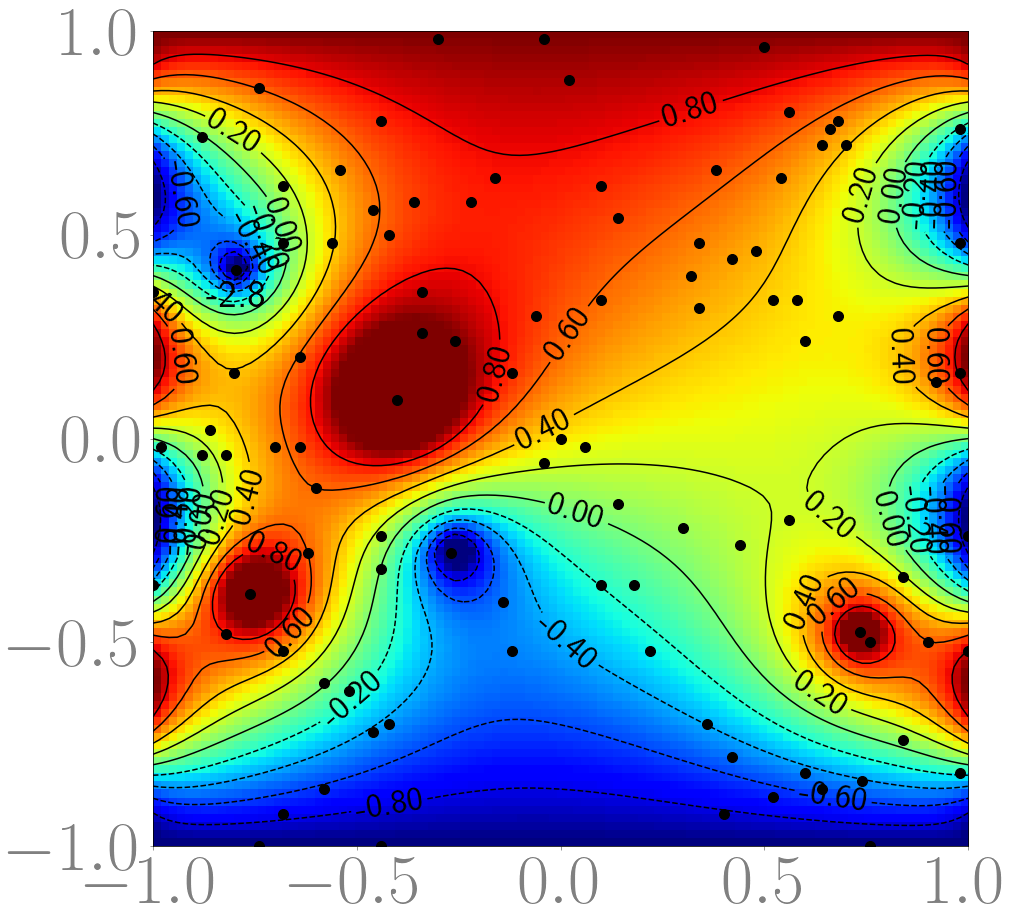

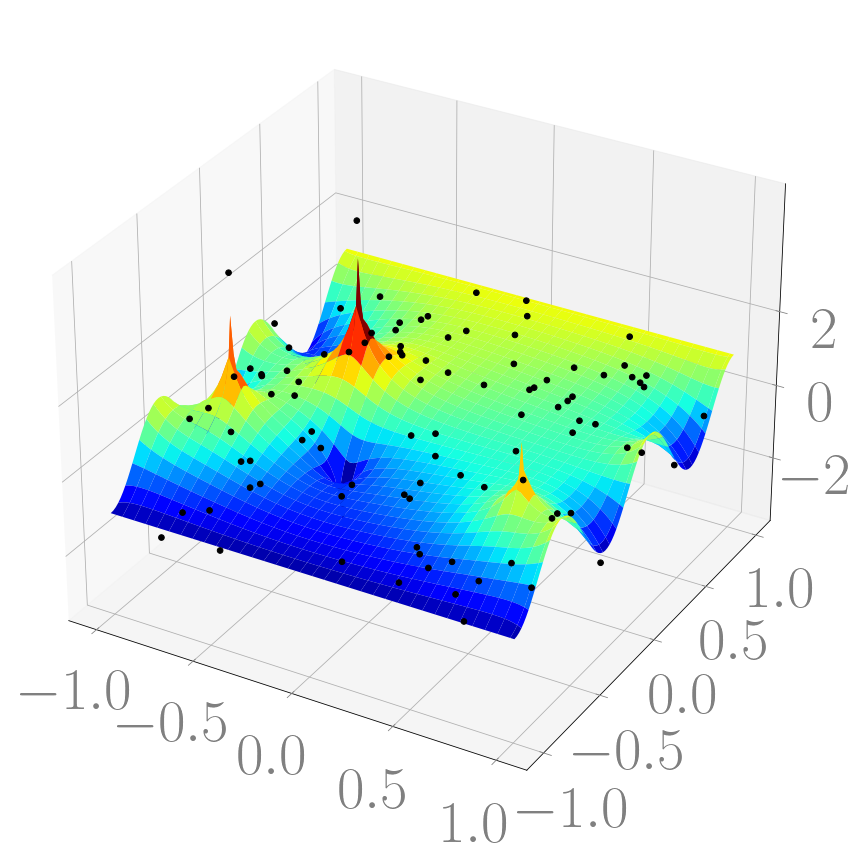

/var/folders/gr/3_667pvs1r9brj7_qpm4cvgc00193z/T/ipykernel_44389/2079212404.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(take_samples(XU_num, sources, n_samples, time_now, 6), dtype=torch.float64)


lambda: 10
min 1.3552192231980342e-05 max 3.3693912478525414 mean 0.261885801938119 std 0.2934628133605028


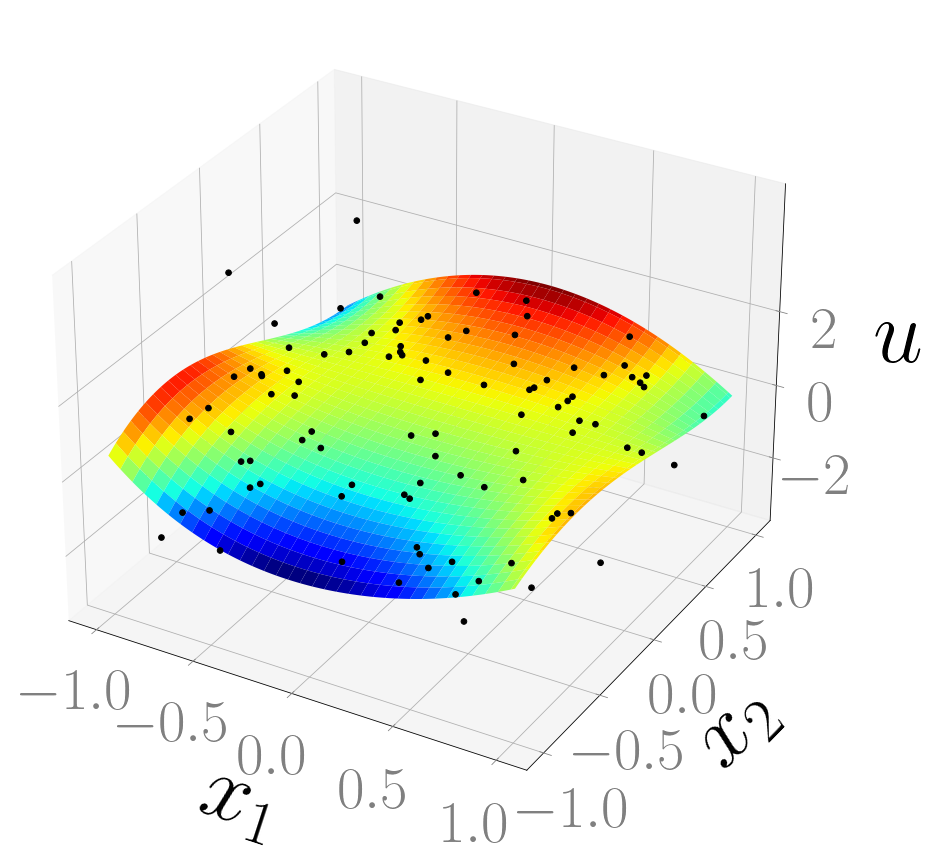

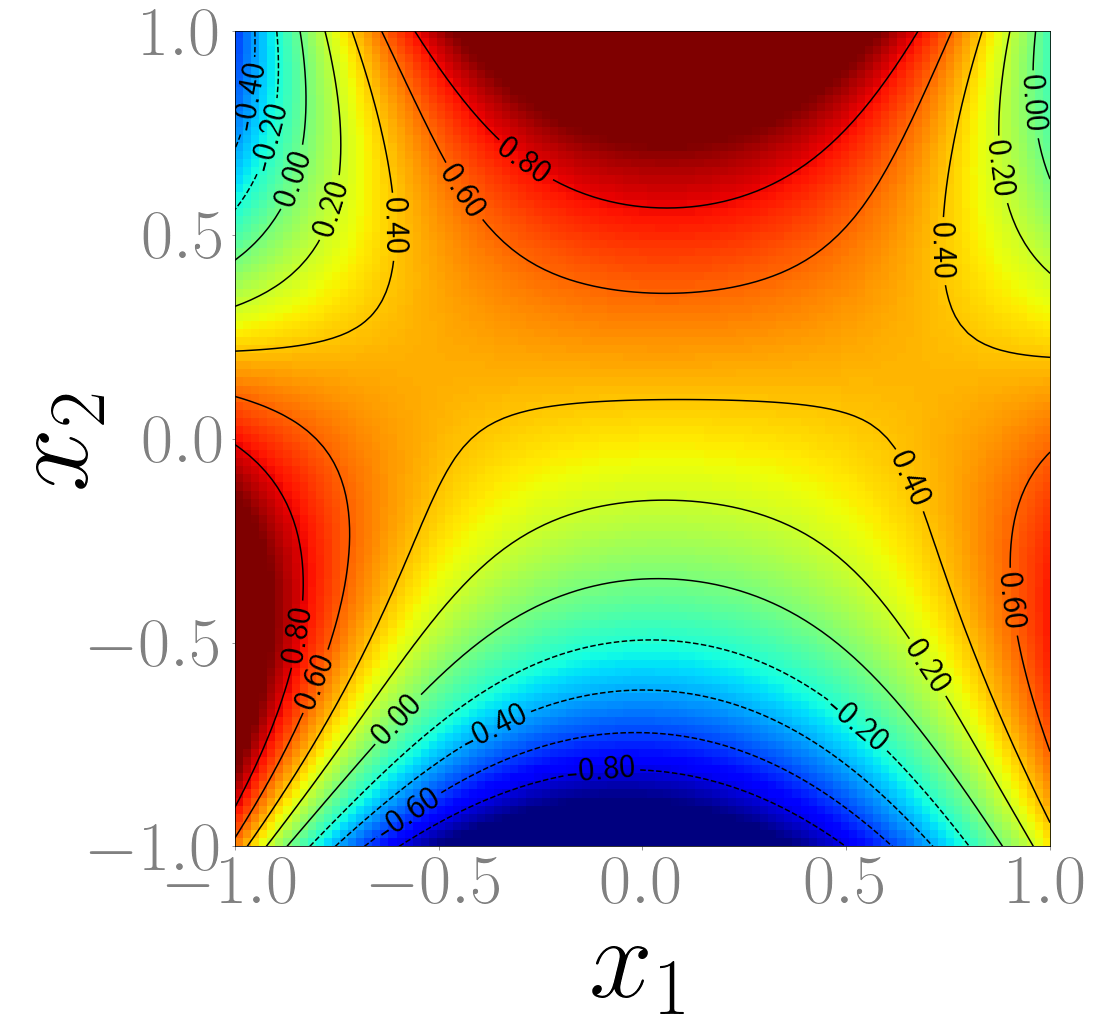

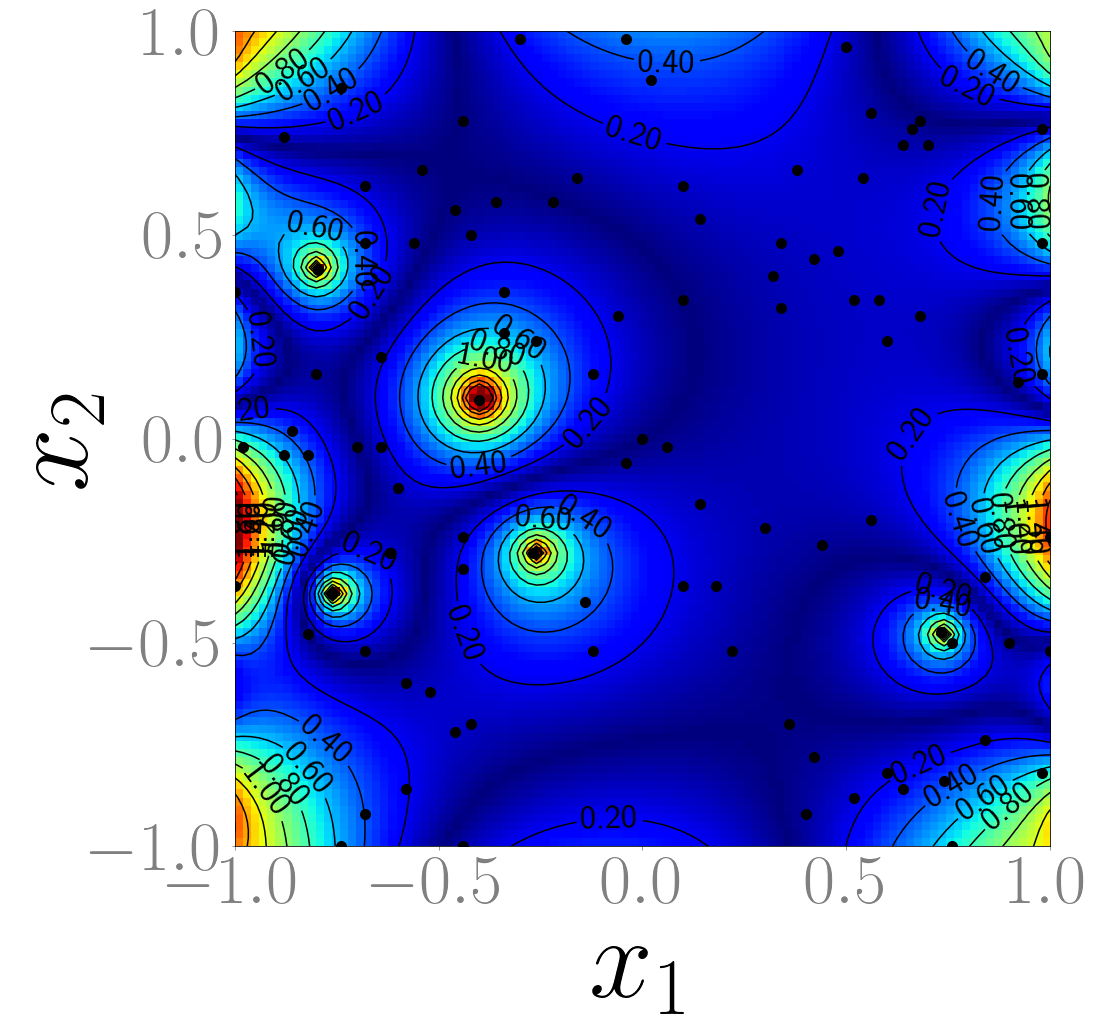

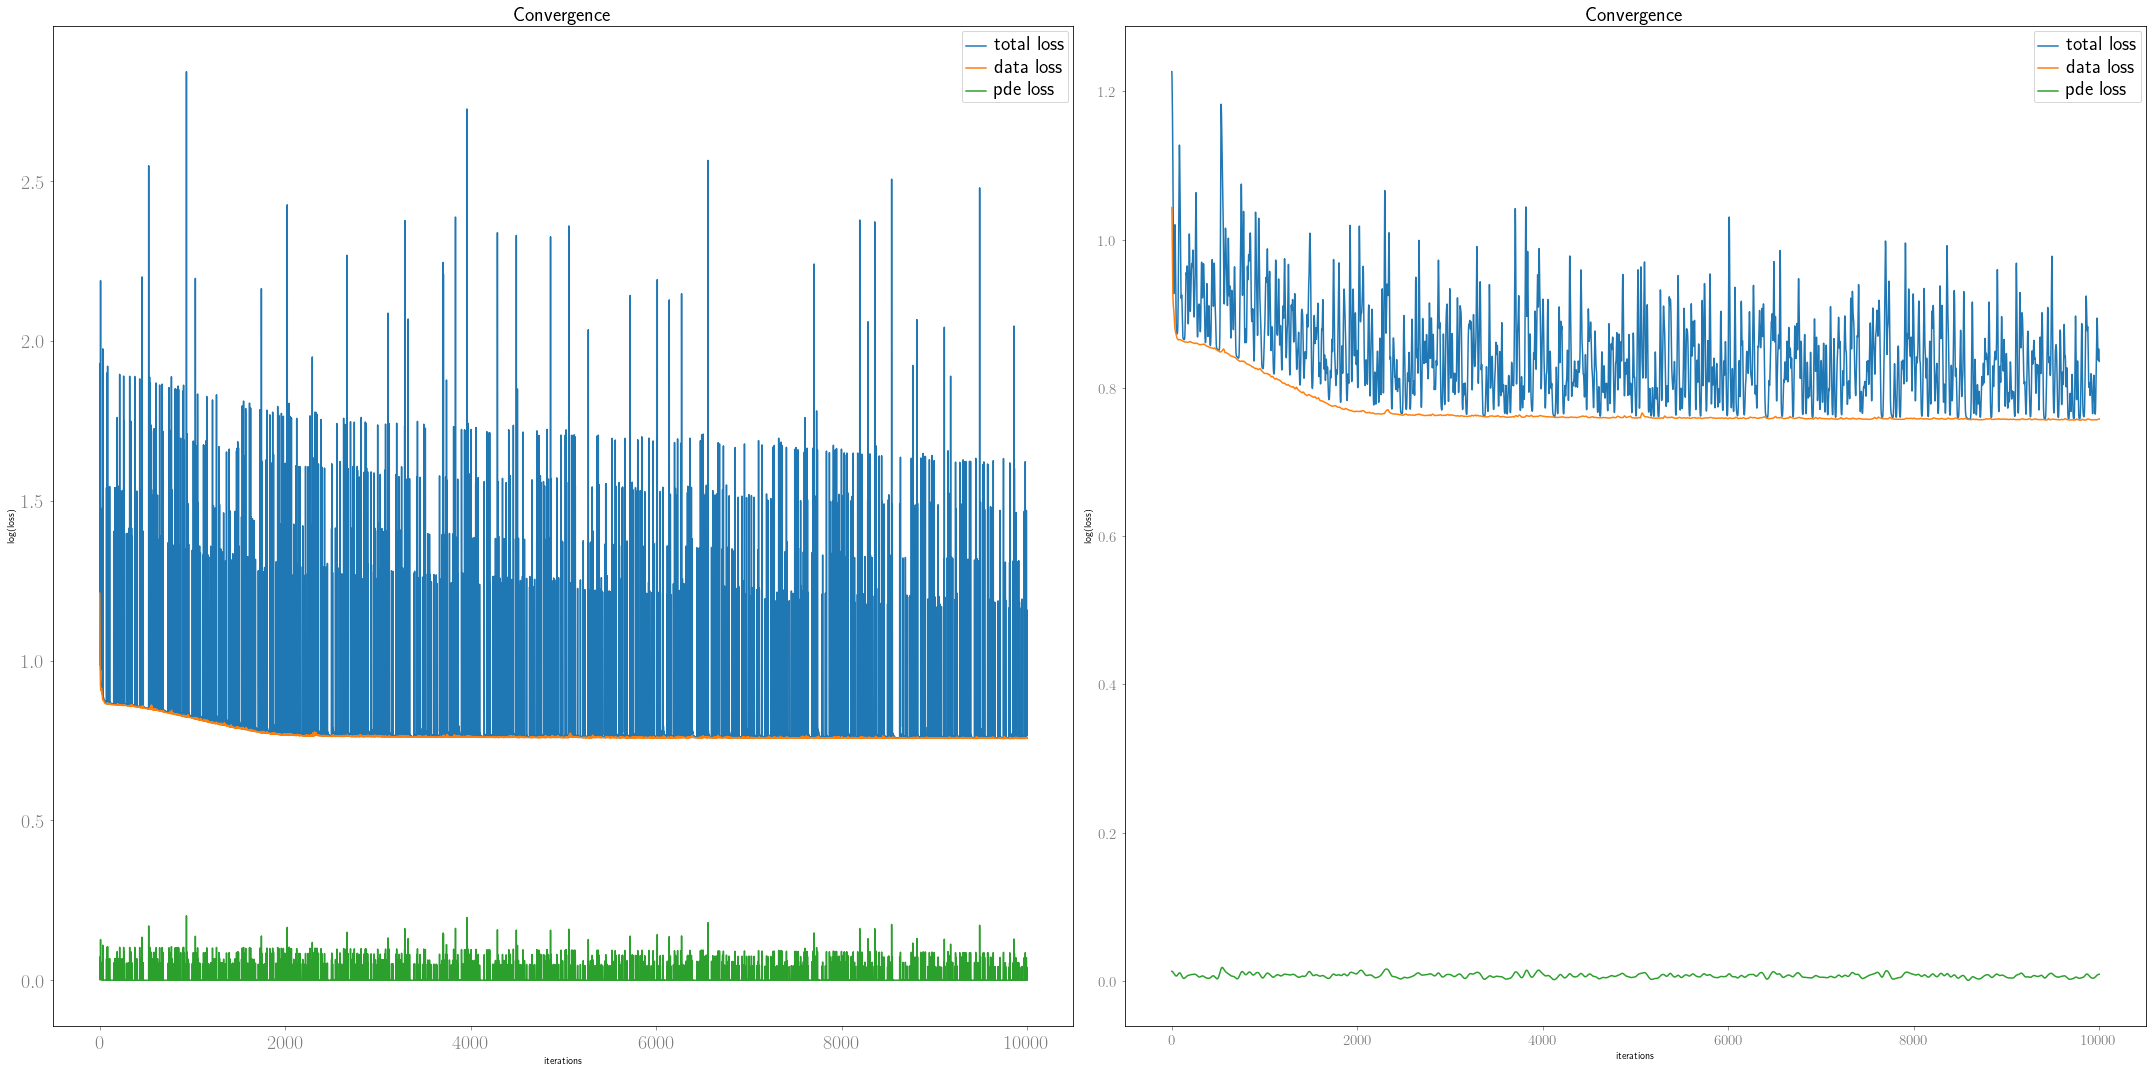

In [17]:
# take samples
n_samples = 100 # number of samples
n_coll = 200 # number of collocation points
show_plots = True
time_now = datetime.now().strftime("%Y%m%d_%H%M")
data = torch.tensor(take_samples(XU_num, sources, n_samples, time_now, 6), dtype=torch.float64)

# pinn initialisation
lr = 0.001 # learning rate
iterations = 10_001
lambda_iterations = 2_001
lambda_physics = calculate_lambda(data, lambda_iterations, n_samples, n_coll, time_now, sources)
print('lambda:', lambda_physics)
pinn, optimiser, mse_loss = initialise_pinn(lr, sources)

# train pinn
show_plots = True
create_plot = True
pinn, end_loss, pinn_mean, pinn_std, u_error_vec = train_pinn(iterations, pinn, optimiser, mse_loss, lambda_physics, data, 0, n_samples, n_coll, time_now, show_plots, create_plot)

## Error calculations


In [ ]:
# error plot for different number of obersevations and integration points
show_plots = False
iterations = 10_001
lambda_iterations = 2_501
lr = 0.001

n_samples = 100
n_coll = 200
show_plots = False
create_plot = True
n_data = 10

error_vec = torch.zeros(n_data,1)
lambdas = []
for i in range(n_data):

    # pinn initialisation
    time_now = datetime.now().strftime("%Y%m%d_%H%M")
    data = torch.tensor(take_samples(XU_num, sources, n_samples, time_now, i), dtype=torch.float64)
    lambda_physics = calculate_lambda(data, lambda_iterations, n_samples, n_coll, time_now, sources)
    lambdas.append(lambda_physics)
    print('n_data:', i, 'lambdas:', lambdas)
    pinn, optimiser, mse_loss = initialise_pinn(lr)

    # train pinn
    pinn, end_loss, pinn_mean, pinn_std, u_error_vec = train_pinn(iterations, pinn, optimiser, mse_loss, lambda_physics, data, i, n_samples, n_coll, time_now, show_plots, create_plot)
    plt.close('all')
    error_vec[i,0] = pinn_mean

# average error tensors in the third dimension
error_mean_avg = torch.mean(error_vec, dim=0)
error_std_avg = torch.std(error_vec, dim=0)
print('mean:', error_mean_avg.item(), 'std:', error_std_avg.item())